In [16]:
Pkg.add("DataFrames")
Pkg.add("Gadfly")


INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of DataFrames
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of Gadfly
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [ ]:
Pkg.update("IJulia")

In [5]:
using DataFrames, Gadfly, Pyplot

In [6]:
# load data
tax = readtable("incomeTaxData.csv")

UndefVarError: UndefVarError: displaysize not defined

You can see just from the first line of the dataset that the there are some rows with no returns associated with it. Let's delete those from the dataset.

Also note that all of the data is in thousands of dollars.

In [25]:
# clean data
tax = tax[!isna(tax[:ReturnCount]), :]; 
sort(tax, cols = :Year) # Colon stated cuz you're stating the actual column name and not the index

# create new columns
tax[:avg_tax] = tax[:TotalTaxLiability]./tax[:ReturnCount];

# a)

Plot the number of returns in Tompkins County over time.


In [26]:
tax_tompkins = tax[(tax[:County] .== "Tompkins"),:]

UndefVarError: UndefVarError: displaysize not defined

In [27]:
size(tax_tompkins)

(194,14)

In [28]:
tompkins_excltotal = tax_tompkins[tax_tompkins[:IncomeClass] .!= "Total",:]


UndefVarError: UndefVarError: displaysize not defined

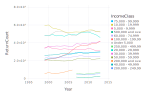

In [29]:
plot(tompkins_excltotal, x=:Year, y =:ReturnCount, Geom.line,color =:IncomeClass)


Plot the average income tax per return in Tompkins County (disregarding income tax).

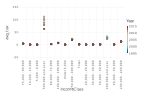

In [30]:
tax_tompkins[:avg_tax] = tax_tompkins[:TotalTaxLiability]./tax_tompkins[:ReturnCount];
plot(tax_tompkins, x=:IncomeClass, y =:avg_tax, color =:Year)

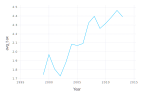

In [31]:
tompkins_total = tax_tompkins[tax_tompkins[:IncomeClass] .== "Total",:]

size(tompkins_total)

plot(tompkins_total, x=:Year, y =:avg_tax, Geom.line)

What kind of plot did you choose to make? Why?

For the 1st plot: Line plot. Easy to see the trend by year, and the income tax class by color.

For the 2nd plot: Scatter plot. Easy to see individual points differentiated by year. For the income classes of "500K and over" and "200K and over", it is clear that different years had different averages, whereas for the other classes, the average stayed around the same across the years.

For the 3rd plot: Line chart. Only need to see the trend of the "Total" average return by year, without differentiating by income classes.

# b)

Continuing to look only at Tompkins County, fit a model that predicts avg_tax using the year number. Do this with least squares.

In [32]:
function plotline(w;
                  xmin=-100,xmax=100)
    xsamples = [xmin, xmax]
    plot(xsamples, [w*x for x in xsamples], color="black")
end

plotline (generic function with 1 method)

In [33]:
tompkins_total = sort(tompkins_total)
X =array(tompkins_total[:,:Year])
Y = array(tompkins_total[:,:avg_tax])
w = X\Y
println(w)

[0.0010612077522817087]


Use convert(Array, da).
 in depwarn at deprecated.jl:73
 in array at C:\Users\User\.julia\v0.4\DataArrays\src\deprecated.jl:23
 in include_string at loading.jl:282
 in execute_request at C:\Users\User\.julia\v0.4\IJulia\src\execute_request.jl:164
 in eventloop at C:\Users\User\.julia\v0.4\IJulia\src\IJulia.jl:138
 in anonymous at task.jl:447
while loading In[33], in expression starting on line 2


Transform the input to include an offset term in the model

In [34]:
X2 = [copy(X) ones(length(X))]
w=X2\Y
println(w)

[0.05272998568828175,-103.64804933914492]


# c)

Now we will change the feature space.
Fit a model using the year and the avg_tax from the previous year.

In [35]:
prev_avgtax = Y[1:length(Y)-1,:] # 14 by 1
years = X[2:length(X),:] #14 by 1
Y2 = Y[2:length(Y),:] # 14 by 1
X3= [years prev_avgtax]
w = X3\Y2
println(w)

[0.00021548417733040904
 0.8169915269988163]


Interpret the coefficients of this. What do they mean?



The average tax rate is linearly proportional to the year and the average tax from the previous year. Over time, the average tax rate increases. As the average tax increases, the average tax for the next year also increases. Note that this shows correlation and not causality.

Plot the real average tax return per year against your model's prediction. Discuss how you think your model fits.



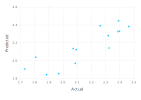

In [36]:
predicted = X3*w
plot(x=Y2, y=predicted, Guide.xlabel("Actual"), Guide.ylabel ("Predicted"), Geom.point)

In [37]:
#error = (predicted.-Y2)'*(predicted.-Y2)
#println(error)

[0.1875467999065635]


In [38]:
w2 = [Y2 ones(length(Y2))]\ predicted
println(w2)

[0.7500555066292176
 0.538875628379709]


The predicted values tend to be slightly higher than the actual values. The model fit can be improved by adding more features.

# d)

Add two new features to your model. This could be a column of the data, a transformation of a column, or a new column formed from another. The only requirement is that the prediction in year $t$ be based on data avilable by the end of year $t-1$

Fit this model and interpret the coefficients. 

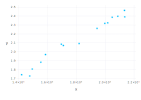

In [39]:
plot(x=tompkins_total[:TotalIncome], y=tompkins_total[:avg_tax])

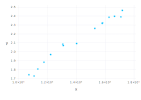

In [40]:
plot(x=tompkins_total[:TotalTaxableIncome], y=tompkins_total[:avg_tax])

In [41]:
X4 = [tompkins_total[:Year, :TotalIncome, :TotalTaxableIncome]]

LoadError: LoadError: MethodError: `getindex` has no method matching getindex(::DataFrames.DataFrame, ::Symbol, ::Symbol, ::Symbol)
Closest candidates are:
  getindex(::DataFrames.DataFrame, !Matched::Real, ::Union{Real,Symbol})
  getindex(::DataFrames.DataFrame, ::Union{Real,Symbol})
  getindex{T<:Real}(::DataFrames.DataFrame, !Matched::AbstractArray{T<:Real,1}, ::Union{Real,Symbol})
  ...
while loading In[41], in expression starting on line 1

# e)

Compare the coefficients from part b and c. Does the coefficient of avg_tax differ in the two models? If so, how do you interpret this difference?

# f)

Now we want to see how this model performs in other counties. Apply the model you fit in part c, with coefficients $w^c$, to data from the other counties and compute the error of this model on each data set.

Plot a histogram of the mean errors the model makes.

Are there major outliers?

# g)

Using the same features you chose in part d, fit a model to the data for each of the other counties. These will be county-specific models. They may have different coefficient vectors from $w^d$.

Plot a histogram of the mean square errors of the county-specific models for their respective counties.

Again, are there major outliers? How do the coefficients compare across counties?